## Data Description - exploratory analysis

In [2]:
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import logging
import import_ipynb
import torch
from torch import optim
from datetime import datetime
import seaborn as sns

from braindecode.datasets import TUH, TUHAbnormal
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)

from PreProcessing_v1 import import_tuh_abnormal
from DataTransform import data_transform, train_valid_test_split, get_parameters_for_model

plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

importing Jupyter notebook from PreProcessing_v1.ipynb
importing Jupyter notebook from DataTransform.ipynb


##### Import TUH Abnormal EEG Corpus

In [3]:
TUH_PATH = 'TUH EEG Abnormal dataset/Abnormal'
N_JOBS = 16  # specify the number of jobs for loading and windowing

tuh_abnormal = import_tuh_abnormal(TUH_PATH, N_JOBS)

##### Calculate stats

In [7]:
male_norm = tuh_abnormal.description.query('gender=="M" and pathological==False')
male_abnm = tuh_abnormal.description.query('gender=="M" and pathological==True')
female_norm = tuh_abnormal.description.query('gender=="F" and pathological==False')
female_abnm = tuh_abnormal.description.query('gender=="F" and pathological==True')
n_bins = 21
d_labels = ['Normal', 'Abnormal']

In [9]:
mean_age = tuh_abnormal.description.groupby(['gender']).mean() # mean of age grouped by gender
std_age = tuh_abnormal.description.groupby(['gender']).std() # standard deviation of age grouped by gender

mean_age_male = mean_age.loc['M']['age'] # mean of age of male patients
std_age_male = std_age.loc['M']['age'] # standard deviation of age of male patients
n_male = len(male_norm) + len(male_abnm) # overall number of male patients' recordings in the data
p_male_norm = (len(male_norm)/n_male)*100 # % of recordings with normal EEG activity out of male patients' data
p_male_abnm = 100 - p_male_norm # % of recordings with abnormal EEG activity out of male patients' data

mean_age_female = mean_age.loc['F']['age'] # mean of age of female patients
std_age_female = std_age.loc['F']['age'] # standard deviation of age of female patients
n_female = len(female_norm) + len(female_abnm) # overall number of female patients' recordings in the data
p_female_norm = (len(female_norm)/n_female)*100 # % of recordings with normal EEG activity out of female patients' data
p_female_abnm = 100 - p_female_norm # % of recordings with abnormal EEG activity out of female patients' data

p_male = (n_male/(n_male + n_female))*100 # % of male patients' recordings out of all records
p_female = 100 - p_male # % of female patients' recordings out of all records

##### Gender/age distribution plot

Text(0.5, 1.0, 'Age Distribution of male and female patients')

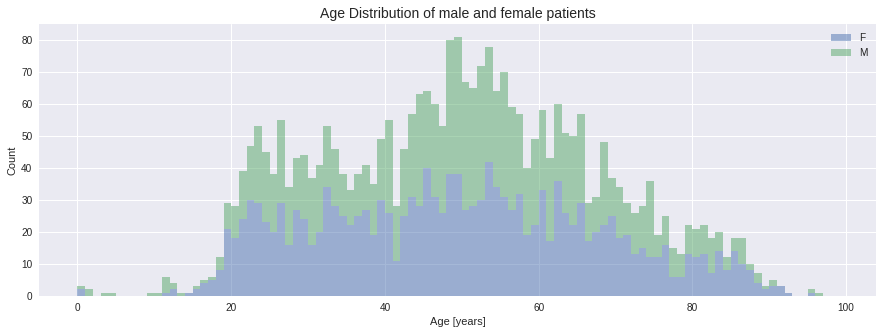

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh_abnormal.description.gender.unique()
x = [tuh_abnormal.description.age[tuh_abnormal.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
ax.set_title("Age Distribution of male and female patients" ,fontsize=14)

##### Number of sessions per patient

Text(0.5, 1.0, 'Occurences of different number of sessions')

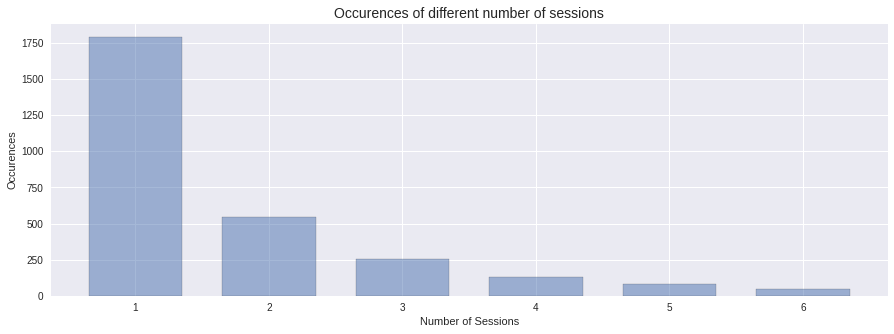

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
x = tuh_abnormal.description.session
ax.hist(
    x=x,
    bins=np.arange(1,8,1)-0.5,
    alpha=.5,
    ec='black',
    rwidth=.7
    
)
ax.set_xlabel('Number of Sessions')
ax.set_ylabel('Occurences')
ax.set_title("Occurences of different number of sessions", fontsize=14)

##### Number of records per year

In [20]:
tuh_abnormal.description.year.unique()

array([2009, 2010, 2011, 2012, 2013])

Text(0.5, 1.0, 'Number of recordings per year')

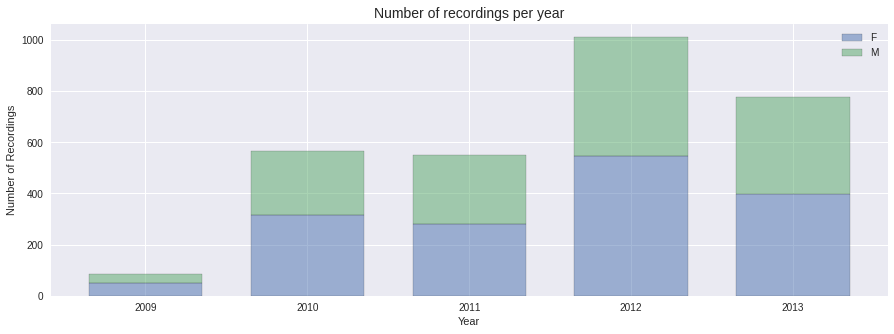

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
x = [tuh_abnormal.description.year[tuh_abnormal.description.gender == g] for g in genders]
ax.hist(
    x=x,
    bins=np.arange(2009,2015,1)-0.5,
    stacked=True,
    alpha=.5,
    ec='black',
    rwidth=.7
    
)
ax.legend(genders)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Recordings')
ax.set_title("Number of recordings per year", fontsize=14)

##### Recordings duration

In [25]:
length = []
for d_i, d in enumerate(tuh_abnormal.datasets):
        length.append(int((d.raw.n_times / d.raw.info['sfreq'])/60))

Text(0.5, 1.0, 'Distribution of recording lengths')

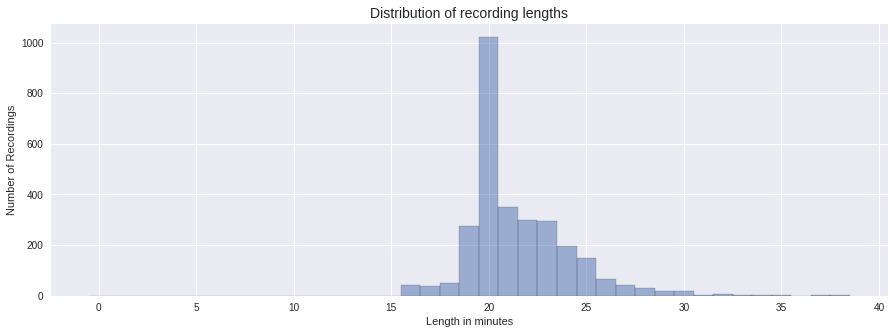

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
x = length
ax.hist(
    x=x,
    bins=np.arange(0,40)-0.5,
    alpha=.5,
    ec='black',
    #rwidth=.7
    
)
ax.set_xlabel('Length in minutes')
ax.set_ylabel('Number of Recordings')
ax.set_title("Distribution of recording lengths", fontsize=14)

##### Abnormal/Normal EEG reports

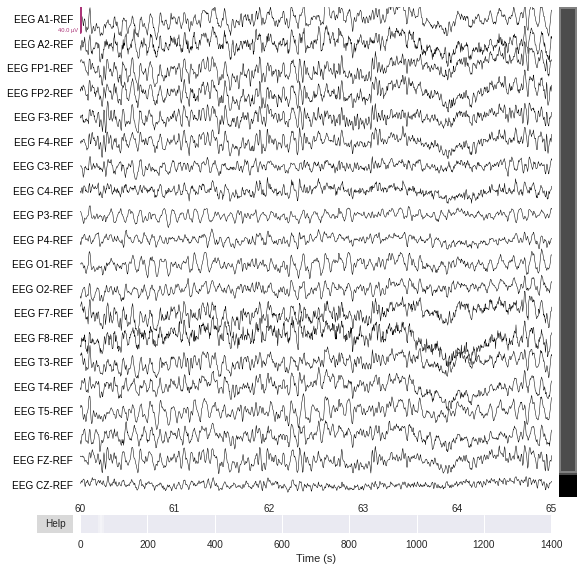

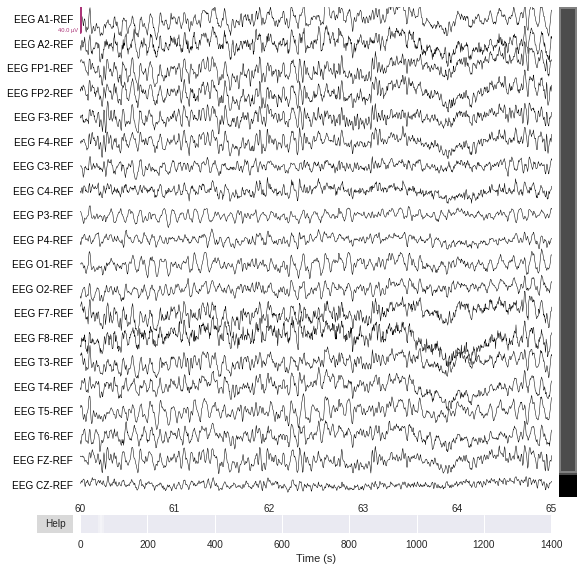

In [60]:
tuh_adults_split = tuh_abnormal.split("pathological")

abnorm, norm = tuh_adults_split['True'], tuh_adults_split['False']
                                              
abnormal_sample = abnorm.datasets[0].raw
normal_sample = norm.datasets[0].raw